**<h1> Convex Optimization - Homework 3 </h1>**

*Boubacar Sow, boubacar.sow@ens-paris-saclay.fr*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [676]:
import numpy as np

def compute_gradient(Q, p, A, b, t, v):
    return t * (2 * Q @ v + p) + ((1 / -(A @ v - b)).T @ A).T

def compute_hessian(Q, A, b, t, v):
    return t * 2 * Q.T + (1 / (A @ v - b)) ** 2 * A.T @ A

def f0(Q, p, v):
    return v.T @ Q @ v + p.T @ v

def f(Q, p, A, b, t, v):
    diff = b - A @ v
    return None if np.any(diff <= 0) else t * f0(Q, p, v) - np.sum(np.log(diff))

def backtracking_line_search(Q, p, A, b, t, v, dv, alpha=0.1, beta=0.7):
    step_size = 1
    # Precompute some values
    f_v = f(Q, p, A, b, t, v)
    grad_dot_dv = np.dot(compute_gradient(Q, p, A, b, t, v).T, dv)
    while True:
        new_v = v + step_size * dv
        f_new_v = f(Q, p, A, b, t, new_v)
        if step_size > 1e-10 and (f_new_v is None or f_new_v > f_v + alpha * step_size * grad_dot_dv):
            step_size *= beta
        else:
            break
    return step_size


def centering_step(Q, p, A, b, t, v0, eps):
    v_seq = []
    k = 0
    while True:
        v_seq.append(v0.copy())
        grad = compute_gradient(Q, p, A, b, t, v0)
        H = compute_hessian(Q, A, b, t, v0)
        dv = -  np.linalg.solve(H, grad)
        newton_decrement = - np.dot(grad.T, dv)
        if (newton_decrement / 2) <= eps:
            return v_seq, k
        step_size = backtracking_line_search(Q, p, A, b, t, v0, dv)
        v0 += step_size * dv

def barrier_method(Q, p, A , b ,v0 , eps=1e-6, mu=15):
    t = 0.1
    v_seq = []
    total_iters = 0
    # Feasibility check or we can assume that v0 is feasible
    while True:
        v_inner_seq, k = centering_step(Q, p, A, b, t, v0, eps)
        v_seq.append(v_inner_seq)
        total_iters += k
        v0 = v_inner_seq[-1]
        if b.shape[0] / t < eps:
            return v_seq, total_iters
        t *= mu
        

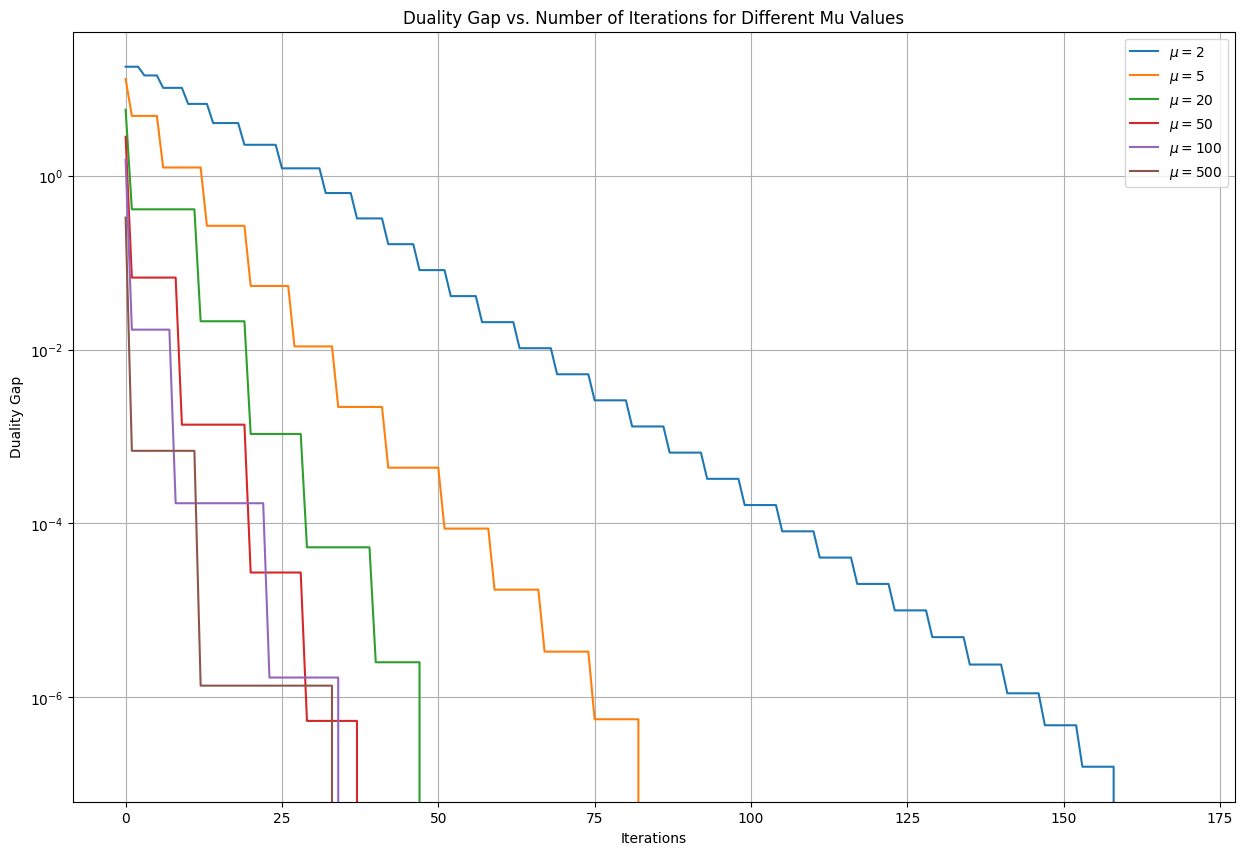

In [683]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_samples = 100
num_features = 50
X, y = np.random.randn(num_samples, num_features), np.random.randn(num_samples)

# Define problem parameters
lambda_ = 10
Q = 0.5 * np.eye(num_samples)
p = -y
A = np.concatenate([X, -X], axis=1).T
b = lambda_ * np.ones(2 * num_features)
v0 = np.zeros(num_samples)
eps = 1e-6

# Set mu values
muues = [2, 5, 20, 50, 100, 500]

plt.figure(figsize=(15, 10))

gaps = []
objective = []
iterations = []

# Loop over mu values
for mu in muues:
    v_list, nb_iterations = barrier_method(Q, p, A, b, v0, eps, mu)
    
    v_sequence = [outer[-1] for outer in v_list for _ in outer]
    optimal_v = v_list[-1][-1]
    optimal_f = f0(Q, p, optimal_v)
    gap = [f0(Q, p, vi) - optimal_f for vi in v_sequence[:-1]]
    gaps.append(gap)
    iterations.append(nb_iterations)
    objective.append(optimal_f)


for g in gaps:
    plt.semilogy(g)

plt.yscale('log')
plt.xlabel('Newton iterations')
plt.ylabel('Duality Gap')
plt.legend([f'$\mu = {mu}$' for mu in muues])
plt.title('Duality Gap vs. Number of Iterations for Different Mu Values')
plt.grid()
plt.show()


We can see here that we have more iterations if $\mu$ is small i.e. $\mu <= 5$ w
When $\mu = 20$, we can still have many outer iterations. We can consider based on the observations that a $\mu$ between 50 and 100 as if we choose a high value of $\mu$, we observe the opposite and we will have more inner iterations.

## **Impact of $\mu$ on $w$**

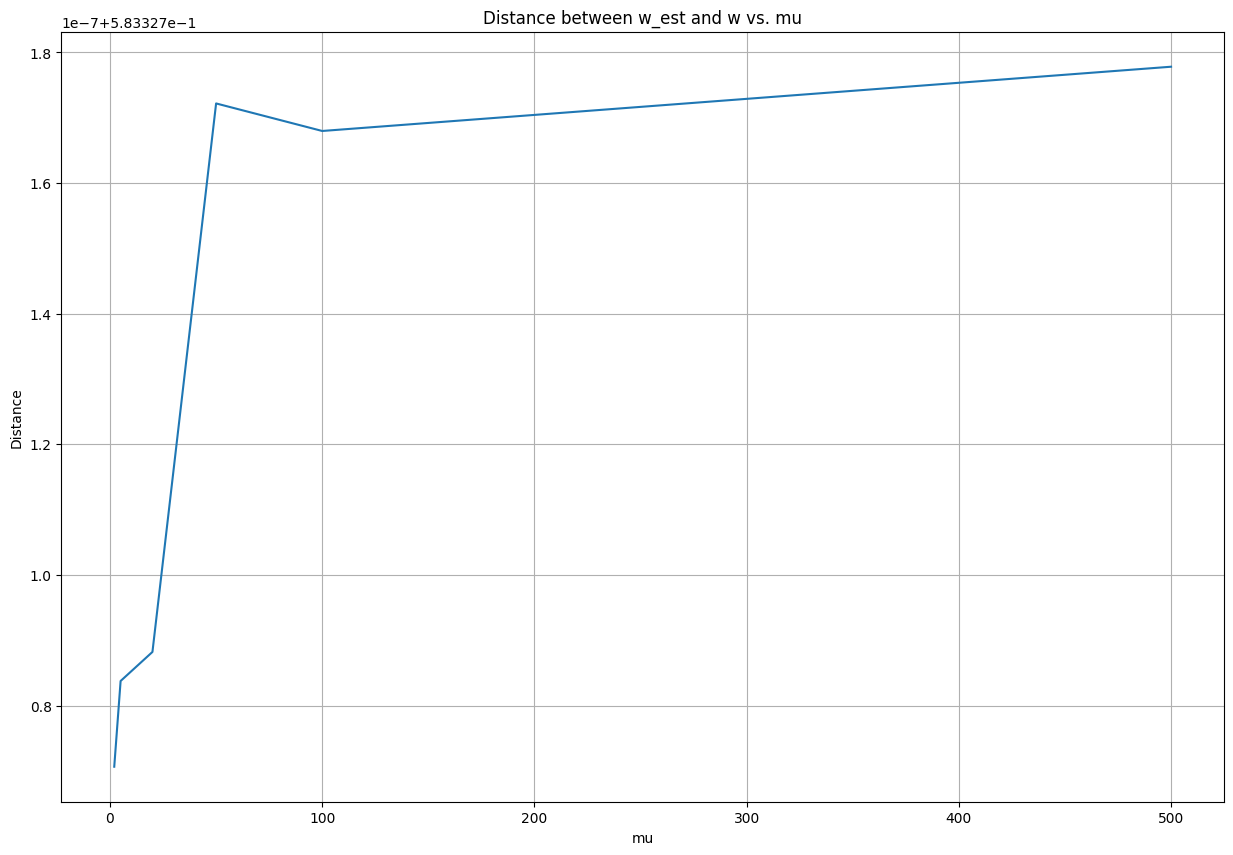

In [687]:
dist = []
w_est_list = []
for m in muues:
    v_list, nb_iterations = barrier_method(Q, p, A, b, v0, eps, m)
    w_est = np.dot(np.linalg.pinv(X), y - v_list[-1][-1]) # KKT condition
    w_est /= np.linalg.norm(w_est)
    w = np.dot(np.linalg.pinv(X), y)
    w /= np.linalg.norm(w)
    dist.append(np.linalg.norm(w_est - w))
    w_est_list.append(w_est)

plt.figure(figsize=(15, 10))
plt.plot(muues, dist)
plt.xlabel('mu')
plt.ylabel('Distance')
plt.title('Distance between w_est and w vs. mu')
plt.grid()
plt.show()

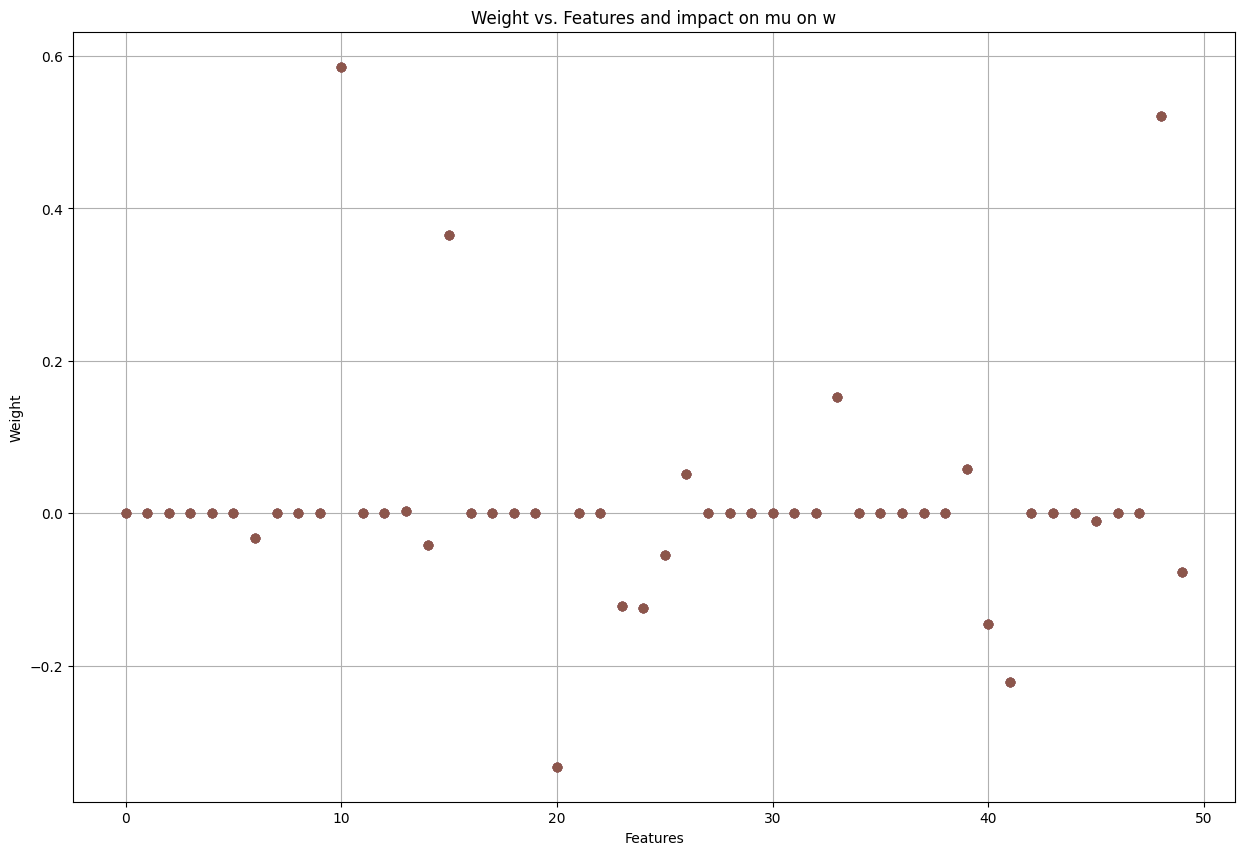

In [698]:
plt.figure(figsize=(15, 10))
for w_est in w_est_list:
    plt.plot(w_est, 'o')
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title('Weight vs. Features and impact on mu on w')
plt.grid()

This seems to be very stable, we cannot even distinguish the colors for the points between the different values of $\mu$. In other words, we always converge to same values of $w$ whatever the value of $\mu$. Obviously, we have several weights at zero, this is expected as it is a property of Lasso regression.

## **Sanity check**

In [680]:
import cvxpy as cp
import numpy as np
from sklearn.datasets import make_regression

# Seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_samples = 20
num_features = 100
X_data, y_data, coef_data = make_regression(n_samples=num_samples, n_features=num_features, coef=True)

# Define problem parameters
lambda_ = 10
Q = 0.5 * np.eye(num_samples)
p = -y_data
A = np.vstack([X_data.T, -X_data.T])
b = lambda_ * np.ones(2 * num_features)
initial_v = np.zeros(num_samples)

# Run barrier method
solution_sequence,_ = barrier_method(Q, p, A, b, initial_v)

# Define and solve the CVXPY problem
variable = cp.Variable(num_samples)
objective = cp.Minimize((cp.quad_form(variable, Q) + p.T @ variable))
constraints = [A @ variable <= b]
problem = cp.Problem(objective, constraints)
problem.solve()

# Display results
print("\n" + "-" * 50)
barrier_solution = solution_sequence[-1][-1]
cvxpy_solution = variable.value
objective_barrier = f0(Q, p, barrier_solution)
objective_cvxpy = problem.value
print("Difference in objective function values: ", np.abs(objective_cvxpy - objective_barrier))
print()
print("Solution from barrier method:", barrier_solution)
print("Solution from CVXPY:", cvxpy_solution)



--------------------------------------------------
Difference in objective function values:  7.802327672834508e-08

Solution from barrier method: [ 0.9759365  -1.70267913  0.38030792  0.31964372  3.98787202 -1.04912036
  0.40283373  0.7250498  -0.36334495 -0.58708938 -2.27209172  1.91771785
  3.63524759  1.38911772 -2.61848496  0.42661692  3.10612045  0.31221236
 -0.70460549  0.24032645]
Solution from CVXPY: [ 0.9759365  -1.70267913  0.38030792  0.31964372  3.98787202 -1.04912036
  0.40283373  0.7250498  -0.36334495 -0.58708938 -2.27209172  1.91771784
  3.63524759  1.38911772 -2.61848496  0.42661692  3.10612045  0.31221236
 -0.70460549  0.24032645]


We can definitely conclude that the implemented algorithm is working perfectly